# Problem statement: 

To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

The dataset consists of 2357 images of malignant and benign oncological diseases, which were formed from the International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:

* Actinic keratosis
* Basal cell carcinoma
* Dermatofibroma
* Melanoma
* Nevus
* Pigmented benign keratosis
* Seborrheic keratosis
* Squamous cell carcinoma
* Vascular lesion

Build a multiclass classification model using a custom convolutional neural network in TensorFlow.

In [1]:
#Importing all the important libraries
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, cv2
import PIL
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential

import warnings
warnings.filterwarnings("ignore")

# Data Reading/Data Understanding

Defining the path for train and test images

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Importing Skin Cancer Data
# Defining the path for train and test images
data_dir_train = pathlib.Path("/kaggle/input/melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path('/kaggle/input/melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Test/')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

2239


In [4]:
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

118


In [5]:
# Define some parameters for the loader
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
# Loading the training data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                               seed=123,
                                                               validation_split=0.2,
                                                               image_size=(img_height,img_width),
                                                               batch_size=batch_size,
                                                               color_mode='rgb',
                                                               subset='training')

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


2022-12-14 05:55:56.649246: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:55:56.650675: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:55:56.668166: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:55:56.669208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-14 05:55:56.670227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [7]:
# Loading the validation data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,
                                                             seed=123,
                                                             validation_split=0.2,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb',
                                                             subset='validation')

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# Loading the testing data
# using seed=123 while creating dataset using tf.keras.preprocessing.image_dataset_from_directory
# resizing images to the size img_height*img_width, while writting the dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_test,
                                                             seed=123,
                                                             image_size=(img_height,img_width),
                                                             batch_size=batch_size,
                                                             color_mode='rgb')

Found 118 files belonging to 9 classes.


In [9]:
# Listing out all the classes of skin cancer and store them in a list. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Dataset visualisation

Creating a code to visualize one instance of all the nine classes present in the dataset

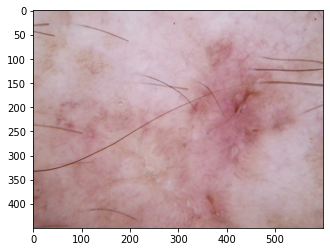

In [10]:
image = plt.imread((list(data_dir_train.glob(class_names[0]+'/*.jpg'))[0]))
plt.imshow(image)

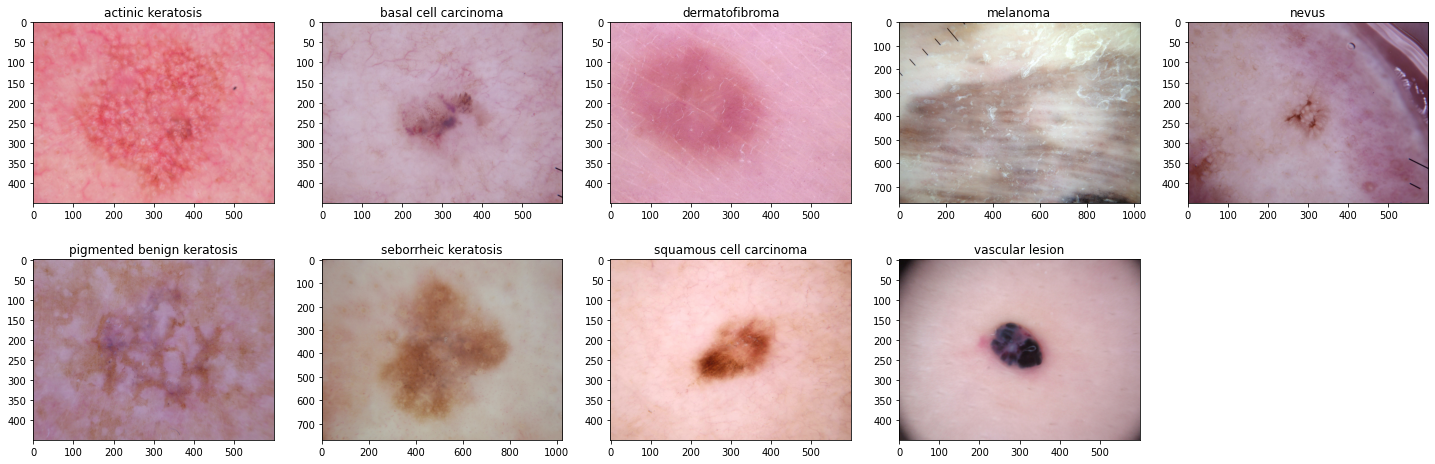

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(25,8))
for i in range(len(class_names)):
  plt.subplot(2,5,i+1)
  image= plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

In [12]:
# Configure the dataset for performance

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# `Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.\
# `Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [13]:
# Method to create plots of the loss and accuracy on the training and validation sets:
def plot_cnn_metrics(history,epochs):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

# Model Building & training : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [14]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [15]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 128)       0         
_________________________________________________________________
flatten (Flatten)            (None, 259200)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               6

In [16]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2022-12-14 05:56:01.775265: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-12-14 05:56:11.900501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:175] Filling up shuffle buffer (this may take a while): 48 of 1000
2022-12-14 05:56:11.967750: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:228] Shuffle buffer filled.
2022-12-14 05:56:12.474304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


56/56 [==============================] - 21s 136ms/step - loss: 2.6716 - accuracy: 0.2773 - val_loss: 1.7292 - val_accuracy: 0.3602
Epoch 2/20
56/56 [==============================] - 4s 63ms/step - loss: 1.6591 - accuracy: 0.4029 - val_loss: 1.5860 - val_accuracy: 0.4273
Epoch 3/20
56/56 [==============================] - 4s 64ms/step - loss: 1.4911 - accuracy: 0.4676 - val_loss: 1.5252 - val_accuracy: 0.4899
Epoch 4/20
56/56 [==============================] - 4s 63ms/step - loss: 1.3263 - accuracy: 0.5301 - val_loss: 1.3971 - val_accuracy: 0.5302
Epoch 5/20
56/56 [==============================] - 4s 63ms/step - loss: 1.2070 - accuracy: 0.5675 - val_loss: 1.3905 - val_accuracy: 0.5168
Epoch 6/20
56/56 [==============================] - 4s 63ms/step - loss: 1.0539 - accuracy: 0.6311 - val_loss: 1.3824 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 4s 63ms/step - loss: 0.9248 - accuracy: 0.6775 - val_loss: 1.6608 - val_accuracy: 0.4855
Epoch 8/20
56/56 [====

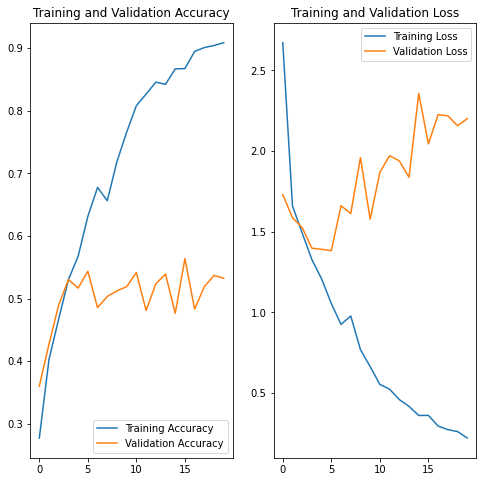

In [17]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy stall at 50% accuracy in training process.</li>
            <li>As the training loss dereases with epochs the validation loss increases.</li>
            <li>The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved around <b>50%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is <b>noticeable</b> which is a sign of overfitting.</li>
        </ol>
    </span>    
</div>

# Choosing an appropriate data augmentation strategy to resolve underfitting/overfitting

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

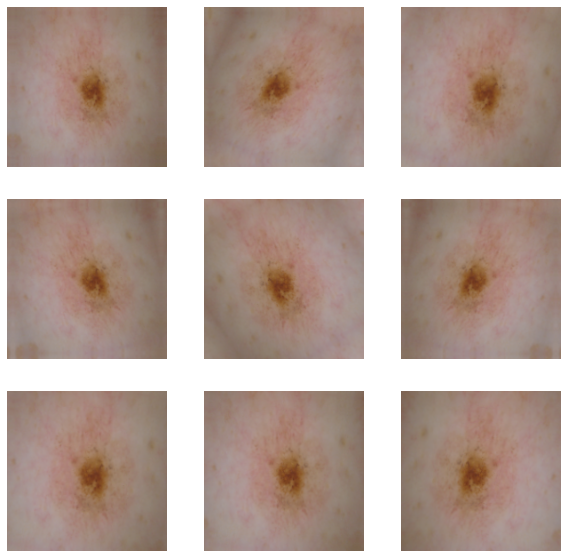

In [19]:
# visualizing how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Model Building & training on the augmented data : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [20]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))

# adding the augmentation layer before the convolution layer
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [21]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 90, 90, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 45, 45, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 259200)           

In [22]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 4s 68ms/step - loss: 2.8043 - accuracy: 0.1775 - val_loss: 2.0737 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: 1.9314 - accuracy: 0.2706 - val_loss: 1.8704 - val_accuracy: 0.2617
Epoch 3/20
56/56 [==============================] - 4s 66ms/step - loss: 1.6842 - accuracy: 0.3834 - val_loss: 1.6111 - val_accuracy: 0.4676
Epoch 4/20
56/56 [==============================] - 4s 65ms/step - loss: 1.5270 - accuracy: 0.4576 - val_loss: 1.4500 - val_accuracy: 0.4922
Epoch 5/20
56/56 [==============================] - 4s 67ms/step - loss: 1.4163 - accuracy: 0.4916 - val_loss: 1.4200 - val_accuracy: 0.5190
Epoch 6/20
56/56 [==============================] - 4s 65ms/step - loss: 1.3797 - accuracy: 0.5011 - val_loss: 1.4532 - val_accuracy: 0.4877
Epoch 7/20
56/56 [==============================] - 4s 66ms/step - loss: 1.3454 - accuracy: 0.5234 - val_loss: 1.3673 - val_accuracy: 0.5235
Epoch 8/20
56

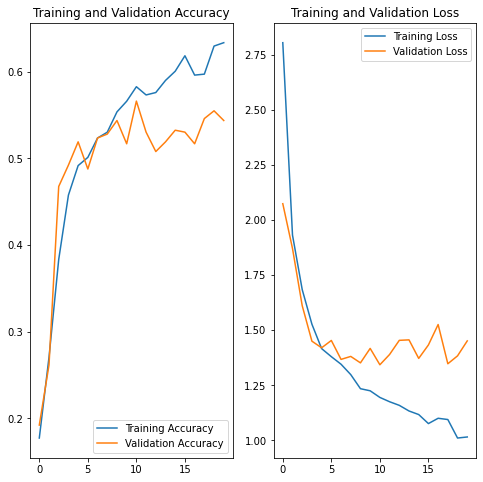

In [23]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.</li>
            <li>As the training loss decreases with epochs the validation loss decreases and stalls.</li>
            <li>The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>55%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is still <b>slightly noticeable</b> which is a sign of overfitting.</li>
        </ol>
    </span>    
</div>

# Model Building & training on the augmented data with dropout : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~20 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [24]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [25]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 90, 90, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 45, 45, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 45, 45, 128)      

In [26]:
# Training the model
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 71ms/step - loss: 3.3922 - accuracy: 0.1853 - val_loss: 2.0345 - val_accuracy: 0.1834
Epoch 2/20
56/56 [==============================] - 4s 68ms/step - loss: 2.0169 - accuracy: 0.2282 - val_loss: 1.9701 - val_accuracy: 0.2573
Epoch 3/20
56/56 [==============================] - 4s 69ms/step - loss: 1.9652 - accuracy: 0.2511 - val_loss: 1.9496 - val_accuracy: 0.3177
Epoch 4/20
56/56 [==============================] - 4s 68ms/step - loss: 1.8389 - accuracy: 0.3270 - val_loss: 1.8363 - val_accuracy: 0.3647
Epoch 5/20
56/56 [==============================] - 4s 68ms/step - loss: 1.6815 - accuracy: 0.3979 - val_loss: 1.6182 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 4s 68ms/step - loss: 1.5185 - accuracy: 0.4621 - val_loss: 1.6244 - val_accuracy: 0.4139
Epoch 7/20
56/56 [==============================] - 4s 69ms/step - loss: 1.4020 - accuracy: 0.5000 - val_loss: 1.6222 - val_accuracy: 0.3915
Epoch 8/20
56

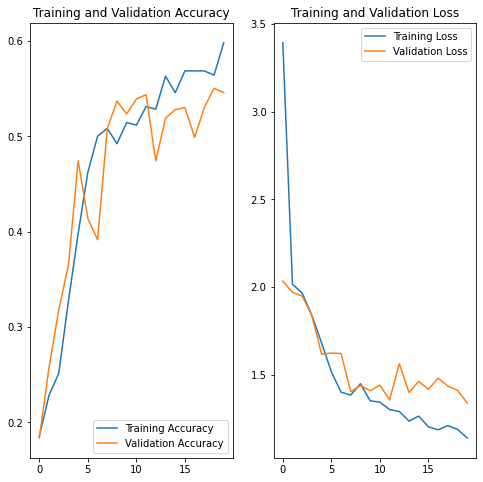

In [27]:
# Visualizing training results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy increases and stall at 55% accuracy in training process.</li>
            <li><b>As the training loss decreases with epochs the validation loss decreases</b></li>
            <li>The plots show that gap between training accuracy and validation accuracy have decreased from previous model, and it has achieved around <b>55%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is <b>very less</b></li>
        </ol>
    </span>    
</div>

### **We can clearly see that the overfitting of the model has redused significantly when compared the earlier models**

# Class distribution: 

Examining the current class distribution in the training dataset

Datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. 

Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [28]:
for i in range(len(class_names)):
  print(class_names[i],' - ',len(list(data_dir_train.glob(class_names[i]+'/*.jpg'))))

actinic keratosis  -  114
basal cell carcinoma  -  376
dermatofibroma  -  95
melanoma  -  438
nevus  -  357
pigmented benign keratosis  -  462
seborrheic keratosis  -  77
squamous cell carcinoma  -  181
vascular lesion  -  139


<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>Which class has the least number of samples?<br>
            <b>seborrheic keratosis with 77 samples</b></li>
            <li>Which classes dominate the data in terms proportionate number of samples?<br>
            <b>pigmented benign keratosis with 462 samples</b></li>
        </ol>
    </span>    
</div>

# Handling class imbalances: 

Rectifing class imbalances present in the training dataset with Augmentor library.

In [29]:
!pip install Augmentor

In [30]:
#import shutil
#shutil.rmtree("/kaggle/working/")

In [31]:
path_to_training_dataset="/kaggle/input/melanoma/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i,output_directory="/kaggle/working/melanoma/"+i+"/")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /kaggle/working/melanoma/actinic keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F97102DF650>: 100%|██████████| 500/500 [00:16<00:00, 30.09 Samples/s]                  


Initialised with 376 image(s) found.
Output directory set to /kaggle/working/melanoma/basal cell carcinoma/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F97102591D0>: 100%|██████████| 500/500 [00:15<00:00, 31.67 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /kaggle/working/melanoma/dermatofibroma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9710032A10>: 100%|██████████| 500/500 [00:17<00:00, 29.34 Samples/s]                  


Initialised with 438 image(s) found.
Output directory set to /kaggle/working/melanoma/melanoma/.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F971014EC10>: 100%|██████████| 500/500 [01:28<00:00,  5.66 Samples/s]                   


Initialised with 357 image(s) found.
Output directory set to /kaggle/working/melanoma/nevus/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=824x719 at 0x7F96F052D1D0>: 100%|██████████| 500/500 [01:20<00:00,  6.20 Samples/s]  


Initialised with 462 image(s) found.
Output directory set to /kaggle/working/melanoma/pigmented benign keratosis/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9710260A50>: 100%|██████████| 500/500 [00:17<00:00, 29.36 Samples/s]                  


Initialised with 77 image(s) found.
Output directory set to /kaggle/working/melanoma/seborrheic keratosis/.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F9710180790>: 100%|██████████| 500/500 [00:41<00:00, 12.17 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /kaggle/working/melanoma/squamous cell carcinoma/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F96F0429550>: 100%|██████████| 500/500 [00:16<00:00, 29.89 Samples/s]                  


Initialised with 139 image(s) found.
Output directory set to /kaggle/working/melanoma/vascular lesion/.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F96F04228D0>: 100%|██████████| 500/500 [00:16<00:00, 31.23 Samples/s]                  


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
data_dir_train = pathlib.Path("/kaggle/working/melanoma/")
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)

9000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [33]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]

In [34]:
dict_new = dict(zip(path_list, lesion_list_new))
df = pd.DataFrame(list(dict_new.items()),columns = ['Path','Label'])

In [35]:
df['Label'].value_counts()

vascular lesion               1000
melanoma                      1000
actinic keratosis             1000
basal cell carcinoma          1000
dermatofibroma                1000
nevus                         1000
pigmented benign keratosis    1000
squamous cell carcinoma       1000
seborrheic keratosis          1000
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

In [36]:
# initializing the parameter to load the images
batch_size = 32
img_height = 180
img_width = 180

In [37]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 7200 files for training.


In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9000 files belonging to 9 classes.
Using 1800 files for validation.


# Model Building & training on the rectified class imbalance data : 

* Creating a CNN model, which can accurately detect 9 classes present in the dataset. While building the model, rescaling images to normalize pixel values between (0,1).
* Choosing an appropriate optimiser and loss function for model training
* Training the model for ~30 epochs
* Plotting Graph for findings after the model fit to check if there is any evidence of model overfit or underfit.

In [39]:
# CNN Model
model=models.Sequential()
# scaling the pixel values from 0-255 to 0-1
model.add(layers.Rescaling(scale=1./255,input_shape=(180,180,3)))
model.add(data_augmentation)

# Convolution layer with 64 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(64,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())

# Convolution layer with 128 features, 3x3 filter and relu activation with 2x2 pooling
model.add(layers.Conv2D(128,(3,3),padding = 'same',activation='relu'))
model.add(layers.MaxPooling2D())
#adding a 20% dropout after the convolution layers
model.add(layers.Dropout(0.2))

model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(9,activation='softmax'))

In [40]:
# Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 45, 45, 128)      

In [41]:
# Training the model
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
225/225 [==============================] - 28s 115ms/step - loss: 2.0176 - accuracy: 0.3496 - val_loss: 1.4640 - val_accuracy: 0.4150
Epoch 2/30
225/225 [==============================] - 26s 114ms/step - loss: 1.3899 - accuracy: 0.4728 - val_loss: 1.2750 - val_accuracy: 0.5222
Epoch 3/30
225/225 [==============================] - 26s 114ms/step - loss: 1.2966 - accuracy: 0.4994 - val_loss: 1.3041 - val_accuracy: 0.4944
Epoch 4/30
225/225 [==============================] - 26s 113ms/step - loss: 1.1936 - accuracy: 0.5507 - val_loss: 1.1581 - val_accuracy: 0.5661
Epoch 5/30
225/225 [==============================] - 26s 112ms/step - loss: 1.1509 - accuracy: 0.5622 - val_loss: 1.3494 - val_accuracy: 0.5011
Epoch 6/30
225/225 [==============================] - 26s 114ms/step - loss: 1.1015 - accuracy: 0.5847 - val_loss: 1.0660 - val_accuracy: 0.5956
Epoch 7/30
225/225 [==============================] - 27s 115ms/step - loss: 1.0146 - accuracy: 0.6157 - val_loss: 1.0594 - val_ac

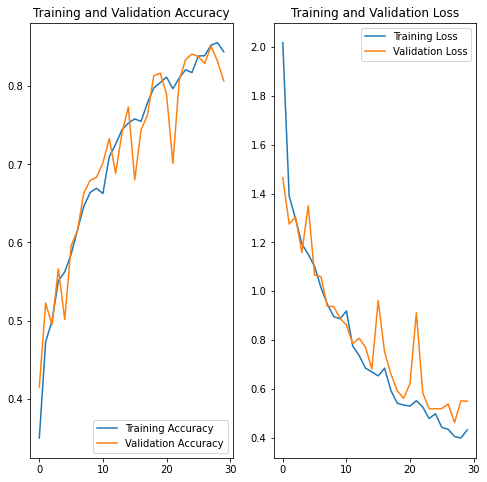

In [42]:
# Visualizing model results
plot_cnn_metrics(history,epochs)

<div class="alert alert-block alert-danger">
    <span style='font-family:Georgia'>
        <b>Findings : </b>
        <ol>
            <li>As the training accuracy increases linearly over time, where as the validation accuracy increases in training process.</li>
            <li>As the training loss decreases with epochs the validation loss also decreases.</li>
            <li>The plots show that gap between training accuracy and validation accuracy have decreased significantly from previous model, and it has achieved around <b>80%</b> accuracy on the validation set.</li>
            <li>The difference in accuracy between training and validation accuracy is <b>very less</b></li>
        </ol>
    </span>    
</div>

<div class="alert alert-block alert-success">
    <span style='font-family:Georgia'>
        <b>Decisive Factor whether an applicant will be Defaulter:</b> <br>
            <p>Class rebalancing not only got rid of overfitting it also improved the accuracy from 55% to 80%.</p>  
    </span>    
</div>